In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchsummary import summary
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import numpy as np

# -----------------------------
# 1. Data Preprocessing
# -----------------------------
data_dir = "/kaggle/input/ju-cricket/Cricket_Dataset_final/Task_B"

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

train_ds = datasets.ImageFolder(f"{data_dir}/train/Umpire", transform=transform)
val_ds   = datasets.ImageFolder(f"{data_dir}/val/Umpire", transform=transform)
test_ds  = datasets.ImageFolder(f"{data_dir}/test/Umpire", transform=transform)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False)

classes = train_ds.classes
print("Classes:", classes)

Classes: ['Four', 'Leg_Bye', 'No_ball', 'Out', 'Six', 'Wide']


In [2]:
print("Total training images:", len(train_ds))
print("Total validation images:", len(val_ds))
print("Total test images:", len(test_ds))

total_images = len(train_ds) + len(val_ds) + len(test_ds)
print("Total images in dataset:", total_images)


Total training images: 1728
Total validation images: 468
Total test images: 585
Total images in dataset: 2781


In [3]:
ignore_folder = "random_occlusion"

def count_images_ignore_folder(dataset, ignore_folder):
    count = 0
    for img_path, label in dataset.samples:
        # Skip if the image path contains the ignore_folder
        if ignore_folder not in img_path.split("/"):
            count += 1
    return count

train_count = count_images_ignore_folder(train_ds, ignore_folder)
val_count   = count_images_ignore_folder(val_ds, ignore_folder)
test_count  = count_images_ignore_folder(test_ds, ignore_folder)

total_count = train_count + val_count + test_count

print("Training images (excluding '{}'): {}".format(ignore_folder, train_count))
print("Validation images (excluding '{}'): {}".format(ignore_folder, val_count))
print("Test images (excluding '{}'): {}".format(ignore_folder, test_count))
print("Total images (excluding '{}'): {}".format(ignore_folder, total_count))


Training images (excluding 'random_occlusion'): 1536
Validation images (excluding 'random_occlusion'): 416
Test images (excluding 'random_occlusion'): 520
Total images (excluding 'random_occlusion'): 2472


In [4]:
ignore_folder = "random_occlusionw"

def get_included_folders(dataset, ignore_folder):
    included = set()
    for img_path, label in dataset.samples:
        # Split the path into parts and ignore if ignore_folder is in the path
        if ignore_folder not in img_path.split("/"):
            # The folder name just above the image (or the class folder)
            folder_name = img_path.split("/")[-2]
            included.add(folder_name)
    return included

train_folders = get_included_folders(train_ds, ignore_folder)
val_folders   = get_included_folders(val_ds, ignore_folder)
test_folders  = get_included_folders(test_ds, ignore_folder)

print("Training folders considered:", train_folders)
print("Validation folders considered:", val_folders)
print("Test folders considered:", test_folders)


Training folders considered: {'original', 'gaussian_noise', 'low_resolution', 'dirty_lens', 'blur', 'random_occlusion', 'chromatic_aberration', 'lens_flare', 'motion_blur'}
Validation folders considered: {'original', 'gaussian_noise', 'low_resolution', 'dirty_lens', 'blur', 'random_occlusion', 'chromatic_aberration', 'lens_flare', 'motion_blur'}
Test folders considered: {'original', 'gaussian_noise', 'low_resolution', 'dirty_lens', 'blur', 'random_occlusion', 'chromatic_aberration', 'lens_flare', 'motion_blur'}


In [5]:
ignore_folder = "random_occlusion"

def filter_samples(dataset, ignore_folder):
    # Keep only samples where ignore_folder is NOT in the path
    filtered_samples = [s for s in dataset.samples if ignore_folder not in s[0].split("/")]
    dataset.samples = filtered_samples
    dataset.targets = [s[1] for s in filtered_samples]  # Update targets accordingly
    return dataset

# Create original datasets
train_ds = datasets.ImageFolder(f"{data_dir}/train/Umpire", transform=transform)
val_ds   = datasets.ImageFolder(f"{data_dir}/val/Umpire", transform=transform)
test_ds  = datasets.ImageFolder(f"{data_dir}/test/Umpire", transform=transform)

# Filter out 'random_occlusion' folder
train_ds = filter_samples(train_ds, ignore_folder)
val_ds   = filter_samples(val_ds, ignore_folder)
test_ds  = filter_samples(test_ds, ignore_folder)

# DataLoaders
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False)

# Classes (will remain the same)
classes = train_ds.classes
print("Classes:", classes)

# Show counts
print("Final Training images:", len(train_ds))
print("Final Validation images:", len(val_ds))
print("Final Test images:", len(test_ds))
print("Total images after filtering:", len(train_ds) + len(val_ds) + len(test_ds))


Classes: ['Four', 'Leg_Bye', 'No_ball', 'Out', 'Six', 'Wide']
Final Training images: 1536
Final Validation images: 416
Final Test images: 520
Total images after filtering: 2472


In [6]:
ignore_folder = "random_occlusion"

def get_included_folders(dataset, ignore_folder):
    included = set()
    for img_path, label in dataset.samples:
        # Split the path into parts and ignore if ignore_folder is in the path
        if ignore_folder not in img_path.split("/"):
            # The folder name just above the image (or the class folder)
            folder_name = img_path.split("/")[-2]
            included.add(folder_name)
    return included

train_folders = get_included_folders(train_ds, ignore_folder)
val_folders   = get_included_folders(val_ds, ignore_folder)
test_folders  = get_included_folders(test_ds, ignore_folder)

print("Training folders considered:", train_folders)
print("Validation folders considered:", val_folders)
print("Test folders considered:", test_folders)


Training folders considered: {'original', 'gaussian_noise', 'low_resolution', 'dirty_lens', 'blur', 'chromatic_aberration', 'lens_flare', 'motion_blur'}
Validation folders considered: {'original', 'gaussian_noise', 'low_resolution', 'dirty_lens', 'blur', 'chromatic_aberration', 'lens_flare', 'motion_blur'}
Test folders considered: {'original', 'gaussian_noise', 'low_resolution', 'dirty_lens', 'blur', 'chromatic_aberration', 'lens_flare', 'motion_blur'}


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import numpy as np
import pandas as pd
from tqdm import tqdm
import time
import os
import tempfile

# -----------------------------
# 1. Data Preprocessing with Filtering (ViT - 224x224)
# -----------------------------
data_dir = "/kaggle/input/ju-cricket/Cricket_Dataset_final/Task_B"

# ViT-B/16 uses 224x224 input size
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ViT-B/16 input size
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

ignore_folder = "random_occlusion"

def filter_samples(dataset, ignore_folder):
    """Filter out samples containing the ignore_folder in their path"""
    filtered_samples = [s for s in dataset.samples if ignore_folder not in s[0].split("/")]
    dataset.samples = filtered_samples
    dataset.targets = [s[1] for s in filtered_samples]
    return dataset

# Create and filter datasets
print("🔄 Loading and filtering datasets for Vision Transformer...")
train_ds = datasets.ImageFolder(f"{data_dir}/train/Umpire", transform=transform)
val_ds   = datasets.ImageFolder(f"{data_dir}/val/Umpire", transform=transform)
test_ds  = datasets.ImageFolder(f"{data_dir}/test/Umpire", transform=transform)

# Apply filtering
train_ds = filter_samples(train_ds, ignore_folder)
val_ds   = filter_samples(val_ds, ignore_folder)
test_ds  = filter_samples(test_ds, ignore_folder)

# Create DataLoaders
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False)

# Display information
classes = train_ds.classes
print(f"✅ Classes: {classes}")
print(f"📊 Dataset Statistics:")
print(f"│ Training images: {len(train_ds)}")
print(f"│ Validation images: {len(val_ds)}")
print(f"│ Test images: {len(test_ds)}")
print(f"│ Total images (after filtering): {len(train_ds) + len(val_ds) + len(test_ds)}")
print(f"│ Excluded folder: '{ignore_folder}'")
print(f"│ Number of classes: {len(classes)}")

🔄 Loading and filtering datasets for Vision Transformer...
✅ Classes: ['Four', 'Leg_Bye', 'No_ball', 'Out', 'Six', 'Wide']
📊 Dataset Statistics:
│ Training images: 1536
│ Validation images: 416
│ Test images: 520
│ Total images (after filtering): 2472
│ Excluded folder: 'random_occlusion'
│ Number of classes: 6


In [8]:
# -----------------------------
# 2. Pretrained Vision Transformer Model
# -----------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load pretrained Vision Transformer (ViT-B/16)
print("🔄 Loading pretrained Vision Transformer (ViT-B/16) from ImageNet...")
model = models.vit_b_16(pretrained=True)

# Replace final classification layer
# ViT uses model.heads.head (nested structure)
num_features = model.heads.head.in_features  # Get input features (768)
model.heads.head = nn.Linear(num_features, len(classes))  # Replace final layer
model = model.to(device)

print(f"✅ Model loaded with {len(classes)} output classes")

# Calculate model parameters and size
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

# Calculate model file size
with tempfile.NamedTemporaryFile(delete=False, suffix='.pth') as tmp_file:
    torch.save(model.state_dict(), tmp_file.name)
    model_size_mb = os.path.getsize(tmp_file.name) / (1024 * 1024)
    os.unlink(tmp_file.name)

print(f"📊 Total parameters: {total_params:,}")
print(f"📊 Trainable parameters: {trainable_params:,}")
print(f"📊 Model file size: {model_size_mb:.2f} MB")
print(f"📋 Model Architecture:")
print(f"│ Input size: (3, 224, 224)")
print(f"│ ViT-B/16 features: 768")
print(f"│ Output classes: {len(classes)}")
print(f"│ Patch size: 16x16")
print(f"│ Sequence length: 196 patches + 1 CLS token")
print(f"│ Transformer layers: 12")
print(f"│ Attention heads: 12")

Using device: cuda
🔄 Loading pretrained Vision Transformer (ViT-B/16) from ImageNet...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 192MB/s]


✅ Model loaded with 6 output classes
📊 Total parameters: 85,803,270
📊 Trainable parameters: 85,803,270
📊 Model file size: 327.37 MB
📋 Model Architecture:
│ Input size: (3, 224, 224)
│ ViT-B/16 features: 768
│ Output classes: 6
│ Patch size: 16x16
│ Sequence length: 196 patches + 1 CLS token
│ Transformer layers: 12
│ Attention heads: 12



📋 Training Configuration:
│ Model: Vision Transformer ViT-B/16 (pretrained)
│ Optimizer: Adam (lr=0.0001)
│ Loss Function: CrossEntropyLoss
│ Batch Size: 32
│ Device: cuda
│ Data: Filtered (excluding 'random_occlusion')

🚀 Starting Vision Transformer Fine-tuning for 50 epochs...

📈 Epoch 1/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:09<00:00,  1.45s/it, Loss=0.5344, Acc=0.8229]


✅ Training completed in 69.80s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:09<00:00,  1.43it/s, Loss=0.7457, Acc=0.7644]


✅ Validation completed in 9.08s
🌟 New best model found! Validation Loss: 0.7457

📊 Epoch 1 Summary:
│ Train Loss: 0.5344 | Train Acc: 0.8229
│ Val Loss:   0.7457 | Val Acc:   0.7644
│ Train Time: 69.80s | Val Time: 9.08s
│ Total Epoch Time: 78.88s
│ Best Val Loss: 0.7457 (Epoch 1)
│ GPU Memory: 1.3GB / 5.0GB

📈 Epoch 2/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:10<00:00,  1.46s/it, Loss=0.0374, Acc=0.9922]


✅ Training completed in 70.06s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:07<00:00,  1.73it/s, Loss=0.7752, Acc=0.7885]


✅ Validation completed in 7.53s

📊 Epoch 2 Summary:
│ Train Loss: 0.0374 | Train Acc: 0.9922
│ Val Loss:   0.7752 | Val Acc:   0.7885
│ Train Time: 70.06s | Val Time: 7.53s
│ Total Epoch Time: 77.59s
│ Best Val Loss: 0.7457 (Epoch 1)
│ GPU Memory: 1.3GB / 5.0GB

📈 Epoch 3/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:10<00:00,  1.46s/it, Loss=0.0060, Acc=1.0000]


✅ Training completed in 70.20s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:07<00:00,  1.74it/s, Loss=0.6738, Acc=0.8413]


✅ Validation completed in 7.48s
🌟 New best model found! Validation Loss: 0.6738

📊 Epoch 3 Summary:
│ Train Loss: 0.0060 | Train Acc: 1.0000
│ Val Loss:   0.6738 | Val Acc:   0.8413
│ Train Time: 70.20s | Val Time: 7.48s
│ Total Epoch Time: 77.68s
│ Best Val Loss: 0.6738 (Epoch 3)
│ GPU Memory: 1.3GB / 5.0GB

📈 Epoch 4/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:10<00:00,  1.47s/it, Loss=0.0013, Acc=1.0000]


✅ Training completed in 70.51s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:07<00:00,  1.72it/s, Loss=0.6909, Acc=0.8341]


✅ Validation completed in 7.55s

📊 Epoch 4 Summary:
│ Train Loss: 0.0013 | Train Acc: 1.0000
│ Val Loss:   0.6909 | Val Acc:   0.8341
│ Train Time: 70.51s | Val Time: 7.55s
│ Total Epoch Time: 78.06s
│ Best Val Loss: 0.6738 (Epoch 3)
│ GPU Memory: 1.3GB / 5.0GB

📈 Epoch 5/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:10<00:00,  1.47s/it, Loss=0.0008, Acc=1.0000]


✅ Training completed in 70.67s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:07<00:00,  1.74it/s, Loss=0.6885, Acc=0.8389]


✅ Validation completed in 7.48s

📊 Epoch 5 Summary:
│ Train Loss: 0.0008 | Train Acc: 1.0000
│ Val Loss:   0.6885 | Val Acc:   0.8389
│ Train Time: 70.67s | Val Time: 7.48s
│ Total Epoch Time: 78.15s
│ Best Val Loss: 0.6738 (Epoch 3)
│ GPU Memory: 1.3GB / 5.0GB

📈 Epoch 6/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:10<00:00,  1.47s/it, Loss=0.0006, Acc=1.0000]


✅ Training completed in 70.73s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:07<00:00,  1.72it/s, Loss=0.7123, Acc=0.8413]


✅ Validation completed in 7.56s

📊 Epoch 6 Summary:
│ Train Loss: 0.0006 | Train Acc: 1.0000
│ Val Loss:   0.7123 | Val Acc:   0.8413
│ Train Time: 70.73s | Val Time: 7.56s
│ Total Epoch Time: 78.30s
│ Best Val Loss: 0.6738 (Epoch 3)
│ GPU Memory: 1.3GB / 5.0GB

📈 Epoch 7/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:10<00:00,  1.48s/it, Loss=0.0005, Acc=1.0000]


✅ Training completed in 70.91s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:07<00:00,  1.75it/s, Loss=0.7192, Acc=0.8438]


✅ Validation completed in 7.45s

📊 Epoch 7 Summary:
│ Train Loss: 0.0005 | Train Acc: 1.0000
│ Val Loss:   0.7192 | Val Acc:   0.8438
│ Train Time: 70.91s | Val Time: 7.45s
│ Total Epoch Time: 78.36s
│ Best Val Loss: 0.6738 (Epoch 3)
│ GPU Memory: 1.3GB / 5.0GB

📈 Epoch 8/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:10<00:00,  1.48s/it, Loss=0.0004, Acc=1.0000]


✅ Training completed in 70.81s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:07<00:00,  1.74it/s, Loss=0.7301, Acc=0.8413]


✅ Validation completed in 7.47s

📊 Epoch 8 Summary:
│ Train Loss: 0.0004 | Train Acc: 1.0000
│ Val Loss:   0.7301 | Val Acc:   0.8413
│ Train Time: 70.81s | Val Time: 7.47s
│ Total Epoch Time: 78.29s
│ Best Val Loss: 0.6738 (Epoch 3)
│ GPU Memory: 1.3GB / 5.0GB

📈 Epoch 9/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:10<00:00,  1.47s/it, Loss=0.0004, Acc=1.0000]


✅ Training completed in 70.70s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:07<00:00,  1.74it/s, Loss=0.7383, Acc=0.8413]


✅ Validation completed in 7.49s

📊 Epoch 9 Summary:
│ Train Loss: 0.0004 | Train Acc: 1.0000
│ Val Loss:   0.7383 | Val Acc:   0.8413
│ Train Time: 70.70s | Val Time: 7.49s
│ Total Epoch Time: 78.20s
│ Best Val Loss: 0.6738 (Epoch 3)
│ GPU Memory: 1.3GB / 5.0GB

📈 Epoch 10/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:10<00:00,  1.47s/it, Loss=0.0003, Acc=1.0000]


✅ Training completed in 70.77s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:07<00:00,  1.74it/s, Loss=0.7418, Acc=0.8438]


✅ Validation completed in 7.49s

📊 Epoch 10 Summary:
│ Train Loss: 0.0003 | Train Acc: 1.0000
│ Val Loss:   0.7418 | Val Acc:   0.8438
│ Train Time: 70.77s | Val Time: 7.49s
│ Total Epoch Time: 78.27s
│ Best Val Loss: 0.6738 (Epoch 3)
│ GPU Memory: 1.3GB / 5.0GB

📈 Epoch 11/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:10<00:00,  1.48s/it, Loss=0.0003, Acc=1.0000]


✅ Training completed in 70.87s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:07<00:00,  1.75it/s, Loss=0.7524, Acc=0.8413]


✅ Validation completed in 7.42s

📊 Epoch 11 Summary:
│ Train Loss: 0.0003 | Train Acc: 1.0000
│ Val Loss:   0.7524 | Val Acc:   0.8413
│ Train Time: 70.87s | Val Time: 7.42s
│ Total Epoch Time: 78.29s
│ Best Val Loss: 0.6738 (Epoch 3)
│ GPU Memory: 1.3GB / 5.0GB

📈 Epoch 12/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:10<00:00,  1.48s/it, Loss=0.0002, Acc=1.0000]


✅ Training completed in 70.82s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:07<00:00,  1.65it/s, Loss=0.7573, Acc=0.8438]


✅ Validation completed in 7.87s

📊 Epoch 12 Summary:
│ Train Loss: 0.0002 | Train Acc: 1.0000
│ Val Loss:   0.7573 | Val Acc:   0.8438
│ Train Time: 70.82s | Val Time: 7.87s
│ Total Epoch Time: 78.69s
│ Best Val Loss: 0.6738 (Epoch 3)
│ GPU Memory: 1.3GB / 5.0GB

📈 Epoch 13/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:11<00:00,  1.48s/it, Loss=0.0002, Acc=1.0000]


✅ Training completed in 71.03s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:07<00:00,  1.74it/s, Loss=0.7629, Acc=0.8438]


✅ Validation completed in 7.48s

📊 Epoch 13 Summary:
│ Train Loss: 0.0002 | Train Acc: 1.0000
│ Val Loss:   0.7629 | Val Acc:   0.8438
│ Train Time: 71.03s | Val Time: 7.48s
│ Total Epoch Time: 78.51s
│ Best Val Loss: 0.6738 (Epoch 3)
│ GPU Memory: 1.3GB / 5.0GB

📈 Epoch 14/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:10<00:00,  1.48s/it, Loss=0.0002, Acc=1.0000]


✅ Training completed in 70.81s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:07<00:00,  1.73it/s, Loss=0.7696, Acc=0.8438]


✅ Validation completed in 7.50s

📊 Epoch 14 Summary:
│ Train Loss: 0.0002 | Train Acc: 1.0000
│ Val Loss:   0.7696 | Val Acc:   0.8438
│ Train Time: 70.81s | Val Time: 7.50s
│ Total Epoch Time: 78.32s
│ Best Val Loss: 0.6738 (Epoch 3)
│ GPU Memory: 1.3GB / 5.0GB

📈 Epoch 15/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:10<00:00,  1.47s/it, Loss=0.0002, Acc=1.0000]


✅ Training completed in 70.77s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:07<00:00,  1.70it/s, Loss=0.7741, Acc=0.8438]


✅ Validation completed in 7.65s

📊 Epoch 15 Summary:
│ Train Loss: 0.0002 | Train Acc: 1.0000
│ Val Loss:   0.7741 | Val Acc:   0.8438
│ Train Time: 70.77s | Val Time: 7.65s
│ Total Epoch Time: 78.42s
│ Best Val Loss: 0.6738 (Epoch 3)
│ GPU Memory: 1.3GB / 5.0GB

📈 Epoch 16/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:10<00:00,  1.47s/it, Loss=0.0002, Acc=1.0000]


✅ Training completed in 70.64s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:07<00:00,  1.73it/s, Loss=0.7800, Acc=0.8413]


✅ Validation completed in 7.50s

📊 Epoch 16 Summary:
│ Train Loss: 0.0002 | Train Acc: 1.0000
│ Val Loss:   0.7800 | Val Acc:   0.8413
│ Train Time: 70.64s | Val Time: 7.50s
│ Total Epoch Time: 78.14s
│ Best Val Loss: 0.6738 (Epoch 3)
│ GPU Memory: 1.3GB / 5.0GB

📈 Epoch 17/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:10<00:00,  1.47s/it, Loss=0.0002, Acc=1.0000]


✅ Training completed in 70.58s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:07<00:00,  1.74it/s, Loss=0.7870, Acc=0.8413]


✅ Validation completed in 7.49s

📊 Epoch 17 Summary:
│ Train Loss: 0.0002 | Train Acc: 1.0000
│ Val Loss:   0.7870 | Val Acc:   0.8413
│ Train Time: 70.58s | Val Time: 7.49s
│ Total Epoch Time: 78.08s
│ Best Val Loss: 0.6738 (Epoch 3)
│ GPU Memory: 1.3GB / 5.0GB

📈 Epoch 18/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:10<00:00,  1.47s/it, Loss=0.0002, Acc=1.0000]


✅ Training completed in 70.49s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:07<00:00,  1.75it/s, Loss=0.7892, Acc=0.8438]


✅ Validation completed in 7.41s

📊 Epoch 18 Summary:
│ Train Loss: 0.0002 | Train Acc: 1.0000
│ Val Loss:   0.7892 | Val Acc:   0.8438
│ Train Time: 70.49s | Val Time: 7.41s
│ Total Epoch Time: 77.90s
│ Best Val Loss: 0.6738 (Epoch 3)
│ GPU Memory: 1.3GB / 5.0GB

📈 Epoch 19/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:10<00:00,  1.47s/it, Loss=0.0001, Acc=1.0000]


✅ Training completed in 70.67s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:07<00:00,  1.74it/s, Loss=0.7943, Acc=0.8413]


✅ Validation completed in 7.49s

📊 Epoch 19 Summary:
│ Train Loss: 0.0001 | Train Acc: 1.0000
│ Val Loss:   0.7943 | Val Acc:   0.8413
│ Train Time: 70.67s | Val Time: 7.49s
│ Total Epoch Time: 78.16s
│ Best Val Loss: 0.6738 (Epoch 3)
│ GPU Memory: 1.3GB / 5.0GB

📈 Epoch 20/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:10<00:00,  1.47s/it, Loss=0.0001, Acc=1.0000]


✅ Training completed in 70.52s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:07<00:00,  1.74it/s, Loss=0.7993, Acc=0.8413]


✅ Validation completed in 7.48s

📊 Epoch 20 Summary:
│ Train Loss: 0.0001 | Train Acc: 1.0000
│ Val Loss:   0.7993 | Val Acc:   0.8413
│ Train Time: 70.52s | Val Time: 7.48s
│ Total Epoch Time: 78.00s
│ Best Val Loss: 0.6738 (Epoch 3)
│ GPU Memory: 1.3GB / 5.0GB

📈 Epoch 21/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:10<00:00,  1.47s/it, Loss=0.0001, Acc=1.0000]


✅ Training completed in 70.59s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:07<00:00,  1.72it/s, Loss=0.8050, Acc=0.8413]


✅ Validation completed in 7.56s

📊 Epoch 21 Summary:
│ Train Loss: 0.0001 | Train Acc: 1.0000
│ Val Loss:   0.8050 | Val Acc:   0.8413
│ Train Time: 70.59s | Val Time: 7.56s
│ Total Epoch Time: 78.15s
│ Best Val Loss: 0.6738 (Epoch 3)
│ GPU Memory: 1.3GB / 5.0GB

📈 Epoch 22/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:10<00:00,  1.47s/it, Loss=0.0001, Acc=1.0000]


✅ Training completed in 70.60s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:07<00:00,  1.73it/s, Loss=0.8102, Acc=0.8413]


✅ Validation completed in 7.50s

📊 Epoch 22 Summary:
│ Train Loss: 0.0001 | Train Acc: 1.0000
│ Val Loss:   0.8102 | Val Acc:   0.8413
│ Train Time: 70.60s | Val Time: 7.50s
│ Total Epoch Time: 78.10s
│ Best Val Loss: 0.6738 (Epoch 3)
│ GPU Memory: 1.3GB / 5.0GB

📈 Epoch 23/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:10<00:00,  1.47s/it, Loss=0.0001, Acc=1.0000]


✅ Training completed in 70.55s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:07<00:00,  1.74it/s, Loss=0.8135, Acc=0.8413]


✅ Validation completed in 7.45s

📊 Epoch 23 Summary:
│ Train Loss: 0.0001 | Train Acc: 1.0000
│ Val Loss:   0.8135 | Val Acc:   0.8413
│ Train Time: 70.55s | Val Time: 7.45s
│ Total Epoch Time: 78.01s
│ Best Val Loss: 0.6738 (Epoch 3)
│ GPU Memory: 1.3GB / 5.0GB

📈 Epoch 24/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:10<00:00,  1.47s/it, Loss=0.0001, Acc=1.0000]


✅ Training completed in 70.60s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:07<00:00,  1.73it/s, Loss=0.8163, Acc=0.8413]


✅ Validation completed in 7.50s

📊 Epoch 24 Summary:
│ Train Loss: 0.0001 | Train Acc: 1.0000
│ Val Loss:   0.8163 | Val Acc:   0.8413
│ Train Time: 70.60s | Val Time: 7.50s
│ Total Epoch Time: 78.10s
│ Best Val Loss: 0.6738 (Epoch 3)
│ GPU Memory: 1.3GB / 5.0GB

📈 Epoch 25/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:10<00:00,  1.47s/it, Loss=0.0001, Acc=1.0000]


✅ Training completed in 70.71s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:07<00:00,  1.71it/s, Loss=0.8221, Acc=0.8413]


✅ Validation completed in 7.62s

📊 Epoch 25 Summary:
│ Train Loss: 0.0001 | Train Acc: 1.0000
│ Val Loss:   0.8221 | Val Acc:   0.8413
│ Train Time: 70.71s | Val Time: 7.62s
│ Total Epoch Time: 78.34s
│ Best Val Loss: 0.6738 (Epoch 3)
│ GPU Memory: 1.3GB / 5.0GB

📈 Epoch 26/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:10<00:00,  1.47s/it, Loss=0.0001, Acc=1.0000]


✅ Training completed in 70.65s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:07<00:00,  1.74it/s, Loss=0.8262, Acc=0.8413]


✅ Validation completed in 7.49s

📊 Epoch 26 Summary:
│ Train Loss: 0.0001 | Train Acc: 1.0000
│ Val Loss:   0.8262 | Val Acc:   0.8413
│ Train Time: 70.65s | Val Time: 7.49s
│ Total Epoch Time: 78.14s
│ Best Val Loss: 0.6738 (Epoch 3)
│ GPU Memory: 1.3GB / 5.0GB

📈 Epoch 27/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:10<00:00,  1.47s/it, Loss=0.0001, Acc=1.0000]


✅ Training completed in 70.72s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:07<00:00,  1.72it/s, Loss=0.8301, Acc=0.8413]


✅ Validation completed in 7.57s

📊 Epoch 27 Summary:
│ Train Loss: 0.0001 | Train Acc: 1.0000
│ Val Loss:   0.8301 | Val Acc:   0.8413
│ Train Time: 70.72s | Val Time: 7.57s
│ Total Epoch Time: 78.29s
│ Best Val Loss: 0.6738 (Epoch 3)
│ GPU Memory: 1.3GB / 5.0GB

📈 Epoch 28/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:10<00:00,  1.48s/it, Loss=0.0001, Acc=1.0000]


✅ Training completed in 70.80s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:07<00:00,  1.74it/s, Loss=0.8341, Acc=0.8413]


✅ Validation completed in 7.47s

📊 Epoch 28 Summary:
│ Train Loss: 0.0001 | Train Acc: 1.0000
│ Val Loss:   0.8341 | Val Acc:   0.8413
│ Train Time: 70.80s | Val Time: 7.47s
│ Total Epoch Time: 78.28s
│ Best Val Loss: 0.6738 (Epoch 3)
│ GPU Memory: 1.3GB / 5.0GB

📈 Epoch 29/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:11<00:00,  1.48s/it, Loss=0.0001, Acc=1.0000]


✅ Training completed in 71.03s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:07<00:00,  1.73it/s, Loss=0.8376, Acc=0.8413]


✅ Validation completed in 7.53s

📊 Epoch 29 Summary:
│ Train Loss: 0.0001 | Train Acc: 1.0000
│ Val Loss:   0.8376 | Val Acc:   0.8413
│ Train Time: 71.03s | Val Time: 7.53s
│ Total Epoch Time: 78.56s
│ Best Val Loss: 0.6738 (Epoch 3)
│ GPU Memory: 1.3GB / 5.0GB

📈 Epoch 30/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:10<00:00,  1.47s/it, Loss=0.0001, Acc=1.0000]


✅ Training completed in 70.71s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:07<00:00,  1.71it/s, Loss=0.8401, Acc=0.8413]


✅ Validation completed in 7.58s

📊 Epoch 30 Summary:
│ Train Loss: 0.0001 | Train Acc: 1.0000
│ Val Loss:   0.8401 | Val Acc:   0.8413
│ Train Time: 70.71s | Val Time: 7.58s
│ Total Epoch Time: 78.30s
│ Best Val Loss: 0.6738 (Epoch 3)
│ GPU Memory: 1.3GB / 5.0GB

📈 Epoch 31/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:10<00:00,  1.47s/it, Loss=0.0001, Acc=1.0000]


✅ Training completed in 70.78s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:07<00:00,  1.75it/s, Loss=0.8431, Acc=0.8413]


✅ Validation completed in 7.44s

📊 Epoch 31 Summary:
│ Train Loss: 0.0001 | Train Acc: 1.0000
│ Val Loss:   0.8431 | Val Acc:   0.8413
│ Train Time: 70.78s | Val Time: 7.44s
│ Total Epoch Time: 78.22s
│ Best Val Loss: 0.6738 (Epoch 3)
│ GPU Memory: 1.3GB / 5.0GB

📈 Epoch 32/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:10<00:00,  1.47s/it, Loss=0.0001, Acc=1.0000]


✅ Training completed in 70.36s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:07<00:00,  1.72it/s, Loss=0.8471, Acc=0.8413]


✅ Validation completed in 7.55s

📊 Epoch 32 Summary:
│ Train Loss: 0.0001 | Train Acc: 1.0000
│ Val Loss:   0.8471 | Val Acc:   0.8413
│ Train Time: 70.36s | Val Time: 7.55s
│ Total Epoch Time: 77.91s
│ Best Val Loss: 0.6738 (Epoch 3)
│ GPU Memory: 1.3GB / 5.0GB

📈 Epoch 33/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:10<00:00,  1.47s/it, Loss=0.0001, Acc=1.0000]


✅ Training completed in 70.65s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:07<00:00,  1.75it/s, Loss=0.8500, Acc=0.8413]


✅ Validation completed in 7.44s

📊 Epoch 33 Summary:
│ Train Loss: 0.0001 | Train Acc: 1.0000
│ Val Loss:   0.8500 | Val Acc:   0.8413
│ Train Time: 70.65s | Val Time: 7.44s
│ Total Epoch Time: 78.09s
│ Best Val Loss: 0.6738 (Epoch 3)
│ GPU Memory: 1.3GB / 5.0GB

📈 Epoch 34/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:10<00:00,  1.47s/it, Loss=0.0001, Acc=1.0000]


✅ Training completed in 70.63s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:07<00:00,  1.73it/s, Loss=0.8531, Acc=0.8413]


✅ Validation completed in 7.54s

📊 Epoch 34 Summary:
│ Train Loss: 0.0001 | Train Acc: 1.0000
│ Val Loss:   0.8531 | Val Acc:   0.8413
│ Train Time: 70.63s | Val Time: 7.54s
│ Total Epoch Time: 78.17s
│ Best Val Loss: 0.6738 (Epoch 3)
│ GPU Memory: 1.3GB / 5.0GB

📈 Epoch 35/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:10<00:00,  1.47s/it, Loss=0.0001, Acc=1.0000]


✅ Training completed in 70.64s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:07<00:00,  1.72it/s, Loss=0.8567, Acc=0.8438]


✅ Validation completed in 7.56s

📊 Epoch 35 Summary:
│ Train Loss: 0.0001 | Train Acc: 1.0000
│ Val Loss:   0.8567 | Val Acc:   0.8438
│ Train Time: 70.64s | Val Time: 7.56s
│ Total Epoch Time: 78.21s
│ Best Val Loss: 0.6738 (Epoch 3)
│ GPU Memory: 1.3GB / 5.0GB

📈 Epoch 36/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:10<00:00,  1.48s/it, Loss=0.0001, Acc=1.0000]


✅ Training completed in 70.87s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:07<00:00,  1.71it/s, Loss=0.8589, Acc=0.8462]


✅ Validation completed in 7.59s

📊 Epoch 36 Summary:
│ Train Loss: 0.0001 | Train Acc: 1.0000
│ Val Loss:   0.8589 | Val Acc:   0.8462
│ Train Time: 70.87s | Val Time: 7.59s
│ Total Epoch Time: 78.47s
│ Best Val Loss: 0.6738 (Epoch 3)
│ GPU Memory: 1.3GB / 5.0GB

📈 Epoch 37/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:10<00:00,  1.47s/it, Loss=0.0001, Acc=1.0000]


✅ Training completed in 70.58s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:07<00:00,  1.74it/s, Loss=0.8635, Acc=0.8462]


✅ Validation completed in 7.49s

📊 Epoch 37 Summary:
│ Train Loss: 0.0001 | Train Acc: 1.0000
│ Val Loss:   0.8635 | Val Acc:   0.8462
│ Train Time: 70.58s | Val Time: 7.49s
│ Total Epoch Time: 78.08s
│ Best Val Loss: 0.6738 (Epoch 3)
│ GPU Memory: 1.3GB / 5.0GB

📈 Epoch 38/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:10<00:00,  1.47s/it, Loss=0.0001, Acc=1.0000]


✅ Training completed in 70.45s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:07<00:00,  1.74it/s, Loss=0.8645, Acc=0.8462]


✅ Validation completed in 7.46s

📊 Epoch 38 Summary:
│ Train Loss: 0.0001 | Train Acc: 1.0000
│ Val Loss:   0.8645 | Val Acc:   0.8462
│ Train Time: 70.45s | Val Time: 7.46s
│ Total Epoch Time: 77.92s
│ Best Val Loss: 0.6738 (Epoch 3)
│ GPU Memory: 1.3GB / 5.0GB

📈 Epoch 39/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:10<00:00,  1.47s/it, Loss=0.0001, Acc=1.0000]


✅ Training completed in 70.45s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:07<00:00,  1.73it/s, Loss=0.8698, Acc=0.8462]


✅ Validation completed in 7.52s

📊 Epoch 39 Summary:
│ Train Loss: 0.0001 | Train Acc: 1.0000
│ Val Loss:   0.8698 | Val Acc:   0.8462
│ Train Time: 70.45s | Val Time: 7.52s
│ Total Epoch Time: 77.97s
│ Best Val Loss: 0.6738 (Epoch 3)
│ GPU Memory: 1.3GB / 5.0GB

📈 Epoch 40/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:10<00:00,  1.48s/it, Loss=0.0001, Acc=1.0000]


✅ Training completed in 70.89s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:07<00:00,  1.73it/s, Loss=0.8732, Acc=0.8462]


✅ Validation completed in 7.52s

📊 Epoch 40 Summary:
│ Train Loss: 0.0001 | Train Acc: 1.0000
│ Val Loss:   0.8732 | Val Acc:   0.8462
│ Train Time: 70.89s | Val Time: 7.52s
│ Total Epoch Time: 78.41s
│ Best Val Loss: 0.6738 (Epoch 3)
│ GPU Memory: 1.3GB / 5.0GB

📈 Epoch 41/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:10<00:00,  1.47s/it, Loss=0.0001, Acc=1.0000]


✅ Training completed in 70.68s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:07<00:00,  1.75it/s, Loss=0.8739, Acc=0.8462]


✅ Validation completed in 7.44s

📊 Epoch 41 Summary:
│ Train Loss: 0.0001 | Train Acc: 1.0000
│ Val Loss:   0.8739 | Val Acc:   0.8462
│ Train Time: 70.68s | Val Time: 7.44s
│ Total Epoch Time: 78.13s
│ Best Val Loss: 0.6738 (Epoch 3)
│ GPU Memory: 1.3GB / 5.0GB

📈 Epoch 42/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:10<00:00,  1.47s/it, Loss=0.0001, Acc=1.0000]


✅ Training completed in 70.34s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:07<00:00,  1.73it/s, Loss=0.8773, Acc=0.8462]


✅ Validation completed in 7.52s

📊 Epoch 42 Summary:
│ Train Loss: 0.0001 | Train Acc: 1.0000
│ Val Loss:   0.8773 | Val Acc:   0.8462
│ Train Time: 70.34s | Val Time: 7.52s
│ Total Epoch Time: 77.86s
│ Best Val Loss: 0.6738 (Epoch 3)
│ GPU Memory: 1.3GB / 5.0GB

📈 Epoch 43/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:10<00:00,  1.47s/it, Loss=0.0000, Acc=1.0000]


✅ Training completed in 70.65s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:07<00:00,  1.73it/s, Loss=0.8797, Acc=0.8462]


✅ Validation completed in 7.52s

📊 Epoch 43 Summary:
│ Train Loss: 0.0000 | Train Acc: 1.0000
│ Val Loss:   0.8797 | Val Acc:   0.8462
│ Train Time: 70.65s | Val Time: 7.52s
│ Total Epoch Time: 78.18s
│ Best Val Loss: 0.6738 (Epoch 3)
│ GPU Memory: 1.3GB / 5.0GB

📈 Epoch 44/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:10<00:00,  1.48s/it, Loss=0.0000, Acc=1.0000]


✅ Training completed in 70.90s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:07<00:00,  1.71it/s, Loss=0.8827, Acc=0.8462]


✅ Validation completed in 7.60s

📊 Epoch 44 Summary:
│ Train Loss: 0.0000 | Train Acc: 1.0000
│ Val Loss:   0.8827 | Val Acc:   0.8462
│ Train Time: 70.90s | Val Time: 7.60s
│ Total Epoch Time: 78.50s
│ Best Val Loss: 0.6738 (Epoch 3)
│ GPU Memory: 1.3GB / 5.0GB

📈 Epoch 45/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:10<00:00,  1.47s/it, Loss=0.0000, Acc=1.0000]


✅ Training completed in 70.35s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:07<00:00,  1.72it/s, Loss=0.8828, Acc=0.8462]


✅ Validation completed in 7.54s

📊 Epoch 45 Summary:
│ Train Loss: 0.0000 | Train Acc: 1.0000
│ Val Loss:   0.8828 | Val Acc:   0.8462
│ Train Time: 70.35s | Val Time: 7.54s
│ Total Epoch Time: 77.89s
│ Best Val Loss: 0.6738 (Epoch 3)
│ GPU Memory: 1.3GB / 5.0GB

📈 Epoch 46/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:10<00:00,  1.47s/it, Loss=0.0000, Acc=1.0000]


✅ Training completed in 70.58s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:07<00:00,  1.76it/s, Loss=0.8863, Acc=0.8462]


✅ Validation completed in 7.38s

📊 Epoch 46 Summary:
│ Train Loss: 0.0000 | Train Acc: 1.0000
│ Val Loss:   0.8863 | Val Acc:   0.8462
│ Train Time: 70.58s | Val Time: 7.38s
│ Total Epoch Time: 77.97s
│ Best Val Loss: 0.6738 (Epoch 3)
│ GPU Memory: 1.3GB / 5.0GB

📈 Epoch 47/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:10<00:00,  1.47s/it, Loss=0.0000, Acc=1.0000]


✅ Training completed in 70.54s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:07<00:00,  1.75it/s, Loss=0.8884, Acc=0.8438]


✅ Validation completed in 7.45s

📊 Epoch 47 Summary:
│ Train Loss: 0.0000 | Train Acc: 1.0000
│ Val Loss:   0.8884 | Val Acc:   0.8438
│ Train Time: 70.54s | Val Time: 7.45s
│ Total Epoch Time: 78.00s
│ Best Val Loss: 0.6738 (Epoch 3)
│ GPU Memory: 1.3GB / 5.0GB

📈 Epoch 48/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:10<00:00,  1.47s/it, Loss=0.0000, Acc=1.0000]


✅ Training completed in 70.53s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:07<00:00,  1.75it/s, Loss=0.8906, Acc=0.8438]


✅ Validation completed in 7.43s

📊 Epoch 48 Summary:
│ Train Loss: 0.0000 | Train Acc: 1.0000
│ Val Loss:   0.8906 | Val Acc:   0.8438
│ Train Time: 70.53s | Val Time: 7.43s
│ Total Epoch Time: 77.97s
│ Best Val Loss: 0.6738 (Epoch 3)
│ GPU Memory: 1.3GB / 5.0GB

📈 Epoch 49/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:10<00:00,  1.47s/it, Loss=0.0000, Acc=1.0000]


✅ Training completed in 70.41s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:07<00:00,  1.74it/s, Loss=0.8942, Acc=0.8438]


✅ Validation completed in 7.48s

📊 Epoch 49 Summary:
│ Train Loss: 0.0000 | Train Acc: 1.0000
│ Val Loss:   0.8942 | Val Acc:   0.8438
│ Train Time: 70.41s | Val Time: 7.48s
│ Total Epoch Time: 77.90s
│ Best Val Loss: 0.6738 (Epoch 3)
│ GPU Memory: 1.3GB / 5.0GB

📈 Epoch 50/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 48/48 [01:10<00:00,  1.47s/it, Loss=0.0000, Acc=1.0000]


✅ Training completed in 70.63s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 13/13 [00:07<00:00,  1.76it/s, Loss=0.8945, Acc=0.8462]


✅ Validation completed in 7.37s

📊 Epoch 50 Summary:
│ Train Loss: 0.0000 | Train Acc: 1.0000
│ Val Loss:   0.8945 | Val Acc:   0.8462
│ Train Time: 70.63s | Val Time: 7.37s
│ Total Epoch Time: 78.01s
│ Best Val Loss: 0.6738 (Epoch 3)
│ GPU Memory: 1.3GB / 5.0GB

💾 Best model saved as 'best_cricket_vit_filtered.pth'
📊 Best model stats:
│ Best Epoch: 3
│ Best Val Loss: 0.6738
│ Best Val Acc: 0.8413

💾 Training history saved to 'cricket_vit_filtered_history_pretrained.csv'

🎉 Vision Transformer Fine-tuning Complete!
Total Training Time: 3908.43s (65.1 minutes)
Average Epoch Time: 78.17s

🧪 Loading Best Model for Testing...
✅ Best model from epoch 3 loaded successfully!


Testing: 100%|██████████████████████████████| 17/17 [00:12<00:00,  1.36it/s]


✅ Testing completed in 12.54s

📋 Classification Report:
              precision    recall  f1-score   support

        Four       0.00      0.00      0.00        40
     Leg_Bye       0.88      0.70      0.78        40
     No_ball       0.58      0.79      0.67       104
         Out       0.79      0.94      0.86        48
         Six       0.88      0.92      0.90       152
        Wide       0.85      0.78      0.82       136

    accuracy                           0.77       520
   macro avg       0.66      0.69      0.67       520
weighted avg       0.74      0.77      0.75       520

🎯 Test Accuracy: 0.7712

📊 Cricket Classification Performance (Vision Transformer - Filtered Data):
│ Best Validation Loss: 0.6738 (Epoch 3)
│ Best Validation Acc:  0.8413 (Epoch 3)
│ Final Test Accuracy:  0.7712
│ Val-Test Gap:         0.0702
│ Data Filtering: Excluded 'random_occlusion' folder

💾 Files saved:
│ best_cricket_vit_filtered.pth - Best model weights
│ cricket_vit_filtered_history.csv 

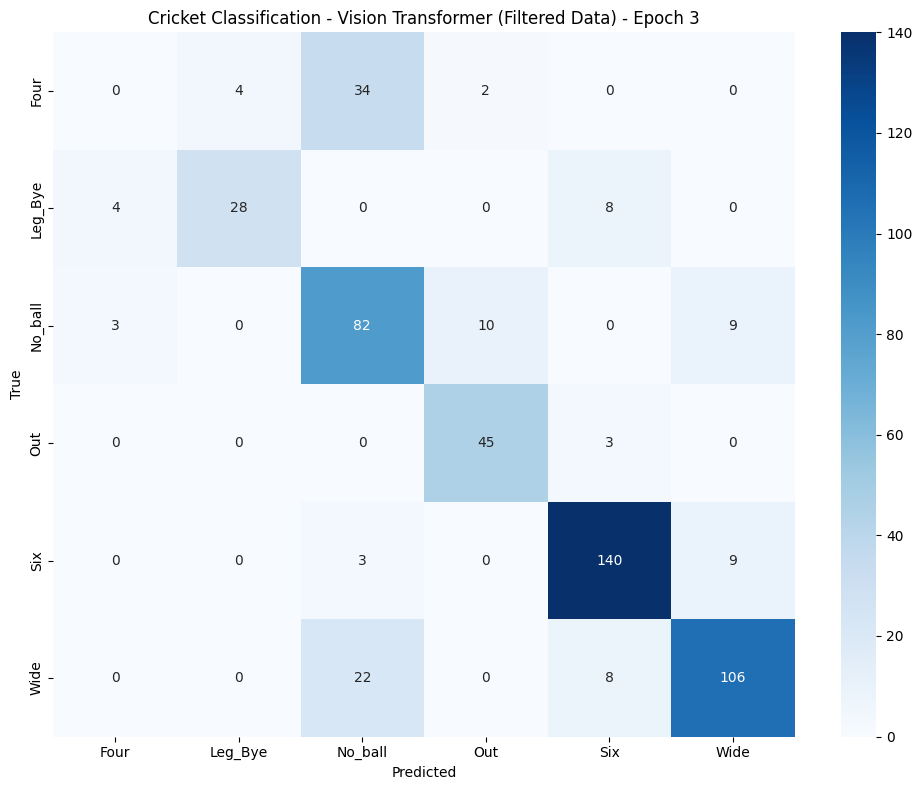

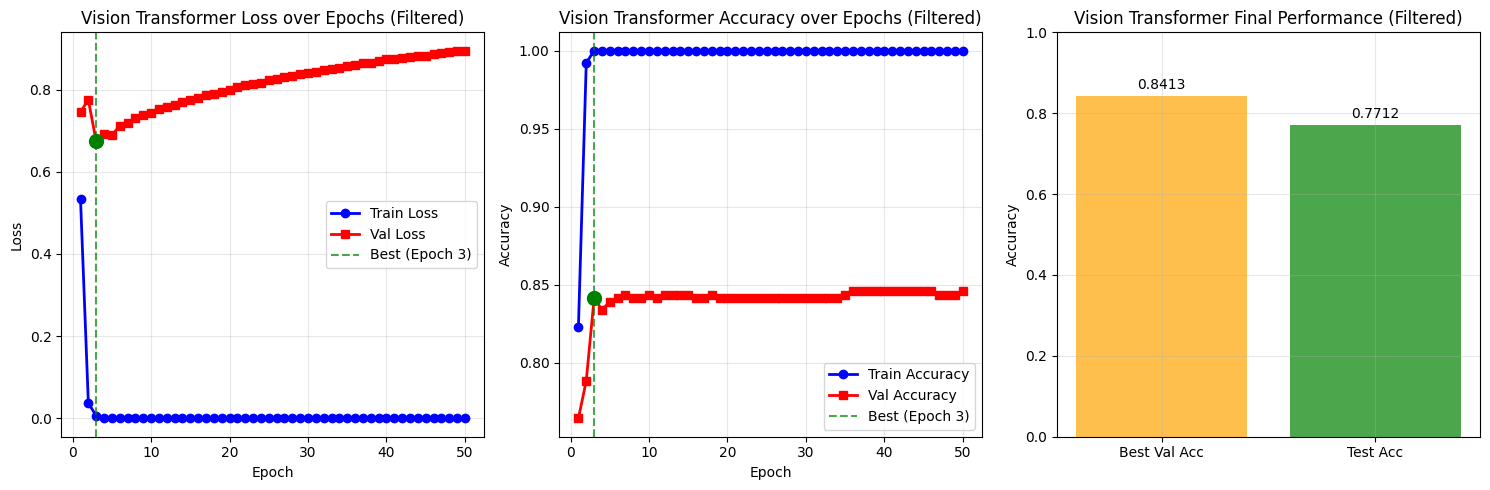


⏰ Final Timing Summary:
│ Total Training: 3908.43s (65.1 min)
│ Average per Epoch: 78.17s
│ Testing Time: 12.54s
│ Total Runtime: 3920.97s

🔍 Vision Transformer + Filtered Data Benefits:
│ Clean dataset: 'random_occlusion' folder excluded
│ Self-attention: Global context understanding
│ Patch-based: 16x16 patches processed as sequences
│ Transformer architecture: State-of-the-art NLP applied to vision
│ ImageNet-21k pretrained: High-quality feature representations
│ Long-range dependencies: Better than CNNs for complex relationships


In [9]:
# -----------------------------
# 3. Training Setup
# -----------------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)  # Lower LR for fine-tuning

print(f"\n📋 Training Configuration:")
print(f"│ Model: Vision Transformer ViT-B/16 (pretrained)")
print(f"│ Optimizer: Adam (lr={optimizer.param_groups[0]['lr']})")
print(f"│ Loss Function: CrossEntropyLoss")
print(f"│ Batch Size: 32")
print(f"│ Device: {device}")
print(f"│ Data: Filtered (excluding '{ignore_folder}')")

# -----------------------------
# 4. Training Loop with Model Saving
# -----------------------------
train_losses, val_losses = [], []
train_accs, val_accs = [], []
epoch_times = []
epochs = 50

# Initialize best model tracking (using val_loss for fine-tuning)
best_val_loss = float('inf')
best_model_state = None
best_epoch = 0
best_val_acc = 0.0

print(f"\n🚀 Starting Vision Transformer Fine-tuning for {epochs} epochs...")
print("=" * 80)
total_start_time = time.time()

for epoch in range(epochs):
    epoch_start_time = time.time()
    
    print(f"\n📈 Epoch {epoch+1}/{epochs}")
    print("-" * 50)
    
    # Training Phase
    print("🔄 Training Phase...")
    model.train()
    running_loss, correct, total = 0, 0, 0
    
    train_pbar = tqdm(train_loader, desc="Training", 
                     bar_format='{l_bar}{bar:30}{r_bar}{bar:-30b}')
    
    train_phase_start = time.time()
    
    for batch_idx, (imgs, labels) in enumerate(train_pbar):
        imgs, labels = imgs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        
        current_acc = correct / total
        train_pbar.set_postfix({
            'Loss': f'{running_loss/(batch_idx+1):.4f}',
            'Acc': f'{current_acc:.4f}'
        })
        
        if device.type == 'cuda' and batch_idx % 10 == 0:
            gpu_memory = torch.cuda.memory_allocated() / 1024**3
            train_pbar.set_postfix({
                'Loss': f'{running_loss/(batch_idx+1):.4f}',
                'Acc': f'{current_acc:.4f}',
                'GPU': f'{gpu_memory:.1f}GB'
            })
    
    train_phase_time = time.time() - train_phase_start
    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    print(f"✅ Training completed in {train_phase_time:.2f}s")
    
    # Validation Phase
    print("🔍 Validation Phase...")
    model.eval()
    running_loss, correct, total = 0, 0, 0
    
    val_phase_start = time.time()
    val_pbar = tqdm(val_loader, desc="Validation", 
                   bar_format='{l_bar}{bar:30}{r_bar}{bar:-30b}')
    
    with torch.no_grad():
        for batch_idx, (imgs, labels) in enumerate(val_pbar):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            
            current_acc = correct / total
            val_pbar.set_postfix({
                'Loss': f'{running_loss/(batch_idx+1):.4f}',
                'Acc': f'{current_acc:.4f}'
            })
    
    val_phase_time = time.time() - val_phase_start
    val_loss = running_loss / len(val_loader)
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    print(f"✅ Validation completed in {val_phase_time:.2f}s")
    
    # Check if this is the best model (using val_loss for fine-tuning)
    is_best = val_loss < best_val_loss
    if is_best:
        best_val_loss = val_loss
        best_val_acc = val_acc
        best_epoch = epoch + 1
        best_model_state = model.state_dict().copy()
        print(f"🌟 New best model found! Validation Loss: {val_loss:.4f}")
    
    # Epoch Summary
    epoch_time = time.time() - epoch_start_time
    epoch_times.append(epoch_time)
    
    print(f"\n📊 Epoch {epoch+1} Summary:")
    print(f"│ Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"│ Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")
    print(f"│ Train Time: {train_phase_time:.2f}s | Val Time: {val_phase_time:.2f}s")
    print(f"│ Total Epoch Time: {epoch_time:.2f}s")
    print(f"│ Best Val Loss: {best_val_loss:.4f} (Epoch {best_epoch})")
    
    if device.type == 'cuda':
        print(f"│ GPU Memory: {torch.cuda.memory_allocated()/1024**3:.1f}GB / {torch.cuda.memory_reserved()/1024**3:.1f}GB")
    
    print("=" * 80)

total_training_time = time.time() - total_start_time

# Save the best model
if best_model_state is not None:
    torch.save(best_model_state, 'best_cricket_vit_filtered_pretrained.pth')
    print(f"\n💾 Best model saved as 'best_cricket_vit_filtered.pth'")
    print(f"📊 Best model stats:")
    print(f"│ Best Epoch: {best_epoch}")
    print(f"│ Best Val Loss: {best_val_loss:.4f}")
    print(f"│ Best Val Acc: {best_val_acc:.4f}")

# Save training history
history_data = {
    'epoch': list(range(1, epochs+1)),
    'train_loss': train_losses,
    'val_loss': val_losses,
    'train_acc': train_accs,
    'val_acc': val_accs,
    'epoch_time': epoch_times
}

history_df = pd.DataFrame(history_data)
history_df.to_csv('cricket_vit_filtered_history_pretrained.csv', index=False)
print("\n💾 Training history saved to 'cricket_vit_filtered_history_pretrained.csv'")

print(f"\n🎉 Vision Transformer Fine-tuning Complete!")
print(f"Total Training Time: {total_training_time:.2f}s ({total_training_time/60:.1f} minutes)")
print(f"Average Epoch Time: {np.mean(epoch_times):.2f}s")

# -----------------------------
# 5. Load Best Model and Test
# -----------------------------
print(f"\n🧪 Loading Best Model for Testing...")
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"✅ Best model from epoch {best_epoch} loaded successfully!")

test_start_time = time.time()
y_true, y_pred = [], []
model.eval()
test_pbar = tqdm(test_loader, desc="Testing", 
                bar_format='{l_bar}{bar:30}{r_bar}{bar:-30b}')

with torch.no_grad():
    for imgs, labels in test_pbar:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

test_time = time.time() - test_start_time
test_accuracy = accuracy_score(y_true, y_pred)

print(f"✅ Testing completed in {test_time:.2f}s")
print("\n📋 Classification Report:")
print(classification_report(y_true, y_pred, target_names=classes))
print(f"🎯 Test Accuracy: {test_accuracy:.4f}")

# Performance Summary
print(f"\n📊 Cricket Classification Performance (Vision Transformer - Filtered Data):")
print(f"│ Best Validation Loss: {best_val_loss:.4f} (Epoch {best_epoch})")
print(f"│ Best Validation Acc:  {best_val_acc:.4f} (Epoch {best_epoch})")
print(f"│ Final Test Accuracy:  {test_accuracy:.4f}")
print(f"│ Val-Test Gap:         {abs(best_val_acc - test_accuracy):.4f}")
print(f"│ Data Filtering: Excluded '{ignore_folder}' folder")

print(f"\n💾 Files saved:")
print(f"│ best_cricket_vit_filtered.pth - Best model weights")
print(f"│ cricket_vit_filtered_history.csv - Training metrics")

# -----------------------------
# 6. Visualizations
# -----------------------------
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Cricket Classification - Vision Transformer (Filtered Data) - Epoch {best_epoch}")
plt.tight_layout()
plt.show()

# Training Curves
plt.figure(figsize=(15, 5))

# Loss Plot
plt.subplot(1, 3, 1)
plt.plot(range(1, epochs+1), train_losses, 'b-', label="Train Loss", marker='o', linewidth=2)
plt.plot(range(1, epochs+1), val_losses, 'r-', label="Val Loss", marker='s', linewidth=2)
plt.axvline(x=best_epoch, color='green', linestyle='--', alpha=0.7, label=f'Best (Epoch {best_epoch})')
plt.scatter([best_epoch], [best_val_loss], color='green', s=100, zorder=5)
plt.legend()
plt.title("Vision Transformer Loss over Epochs (Filtered)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True, alpha=0.3)

# Accuracy Plot
plt.subplot(1, 3, 2)
plt.plot(range(1, epochs+1), train_accs, 'b-', label="Train Accuracy", marker='o', linewidth=2)
plt.plot(range(1, epochs+1), val_accs, 'r-', label="Val Accuracy", marker='s', linewidth=2)
plt.axvline(x=best_epoch, color='green', linestyle='--', alpha=0.7, label=f'Best (Epoch {best_epoch})')
plt.scatter([best_epoch], [best_val_acc], color='green', s=100, zorder=5)
plt.legend()
plt.title("Vision Transformer Accuracy over Epochs (Filtered)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True, alpha=0.3)

# Final Performance
plt.subplot(1, 3, 3)
metrics = ['Best Val Acc', 'Test Acc']
values = [best_val_acc, test_accuracy]
colors = ['orange', 'green']
bars = plt.bar(metrics, values, color=colors, alpha=0.7)
plt.title("Vision Transformer Final Performance (Filtered)")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.grid(True, alpha=0.3)
for bar, val in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.01, 
             f'{val:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Final Summary
print(f"\n⏰ Final Timing Summary:")
print(f"│ Total Training: {total_training_time:.2f}s ({total_training_time/60:.1f} min)")
print(f"│ Average per Epoch: {np.mean(epoch_times):.2f}s")
print(f"│ Testing Time: {test_time:.2f}s")
print(f"│ Total Runtime: {total_training_time + test_time:.2f}s")

# Model and Data Info
print(f"\n🔍 Vision Transformer + Filtered Data Benefits:")
print(f"│ Clean dataset: '{ignore_folder}' folder excluded")
print(f"│ Self-attention: Global context understanding")
print(f"│ Patch-based: 16x16 patches processed as sequences")
print(f"│ Transformer architecture: State-of-the-art NLP applied to vision")
print(f"│ ImageNet-21k pretrained: High-quality feature representations")
print(f"│ Long-range dependencies: Better than CNNs for complex relationships")